Irena Vent

## Natural Language Processing
## 1. Análisis exploratorio de los datos

*   **data**: Amazon Reviews
*   **dataset**: Musical Instruments
*   **obetivo**: obtener un modelo de clasificación binaria que clasifique si una reseña es positiva o negativa

## Preparación del entorno

In [341]:
! wget https://transfer.sh/JGREuX/requirements.txt

--2022-06-19 16:40:08--  https://transfer.sh/JGREuX/requirements.txt
Resolving transfer.sh (transfer.sh)... 144.76.136.153, 2a01:4f8:200:1097::2
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236 [text/plain]
Saving to: ‘requirements.txt.1’

requirements.txt.1  100%[===================>]     236  --.-KB/s    in 0s      

2022-06-19 16:40:10 (21.9 MB/s) - ‘requirements.txt.1’ saved [236/236]



In [342]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [343]:
from utils import load_cinema_reviews

import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

import matplotlib.pyplot as plt

## Carga de datos

In [344]:
#! wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz

In [345]:
#import gzip
#f=gzip.open("./reviews_Musical_Instruments_5.json.gz",'rb')
#file_content=f.read()
#print(file_content)

In [346]:
# drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [347]:
# cargamos Corpus desde drive
#data = pd.read_json('/content/drive/MyDrive/reviews_Patio_Lawn_and_Garden_5.json', lines = True)
data = pd.read_json('/content/drive/MyDrive/reviews_Musical_Instruments_5.json', lines = True)
#data = data.iloc[:10000,:]

# mostramos data
print('Tamaño data -->', data.shape)
pd.set_option('display.max_columns', None)
data.head(5)

Tamaño data --> (10261, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


## Eliminamos columnas no relevantes 

In [348]:
# comprobamos datos
data.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

Nos quedamos con las columnas:


*   reviewText
*   overall



In [349]:
# eliminamos columnas irelevantes
data = data.drop(['reviewerID', 'asin', 'reviewerName', 'helpful', 'summary', 'unixReviewTime', 'reviewTime'], axis = 1)
print('Tamaño del dataset tras elminar columnas -->', data.shape)

Tamaño del dataset tras elminar columnas --> (10261, 2)


## Distribución de de reviews según número de estrellas

In [350]:
# comprobamos el rango de sore
set(data['overall'])

{1, 2, 3, 4, 5}

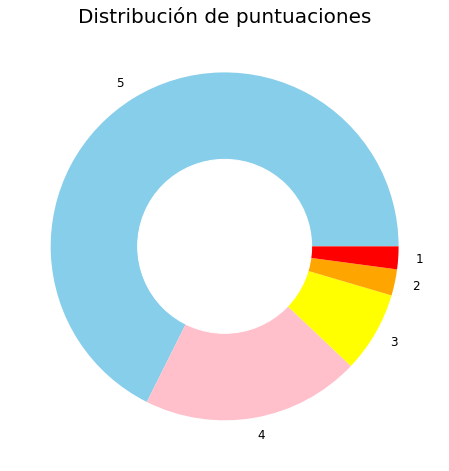

In [351]:
# preparamos los datos
score = data['overall'].value_counts()
numbers = score.index
quantity = score.values

# visualizamos las distribuciones
custom_colors = ['skyblue', 'pink', 'yellow', 'orange', 'red']

plt.figure(figsize=(10, 8))
plt.pie(quantity, labels=numbers, colors=custom_colors)
central_circle = plt.Circle((0, 0), 0.5, color='white')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size=12)
plt.title('Distribución de puntuaciones', fontsize=20)

plt.show()

## Convertimos variable objetivo (reviews) en variable binaria

In [352]:
# nota de conversión:
# overall < 3 = 0 --> negativa
# overall > 3 = 1 --> positiva

# conversión
def label_sentiment(row):
    if int(row['overall']) < 3:
        return 0
    else:
        return 1

data['sentiment_label'] = data.apply(lambda row: label_sentiment(row), axis=1)

In [353]:
data.head(5)

,reviewText,overall,sentiment_label
0,"Not much to write about here, but it does exac...",5,1
1,The product does exactly as it should and is q...,5,1
2,The primary job of this device is to block the...,5,1
3,Nice windscreen protects my MXL mic and preven...,5,1
4,This pop filter is great. It looks and perform...,5,1


## Distribución del dataset según tipo de reseña

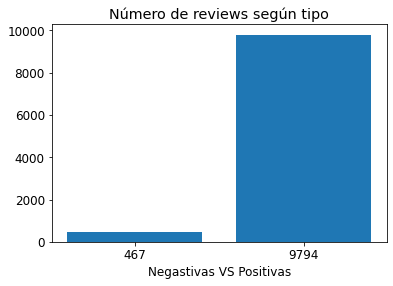

In [354]:
# preparamos los datos
score = data['sentiment_label'].value_counts()
numbers = score.index
quantity = score.values

# visualizamos las distribuciones
plt.bar(numbers, quantity, align='center')
plt.xticks(numbers, quantity)
plt.xlabel('Negastivas VS Positivas')
plt.title('Número de reviews según tipo')

plt.show()

Observamos que el dataset está **desbalanceado**. Es probable que tengamos a aplicar **data augmentation** para reducir el desbalanceo tan elevado entre reseñas positivas y nevaticas. 

## Cardinalidad del vocabulario

Número de frases en todo el dataset

In [355]:
sentences = list()

for review in data[['reviewText']].values:
  for sentnce in review[0].split('.'):
    sentences.append(sentnce)

print(f'Total de frases: {len(sentences)}') 

Total de frases: 74438


Número de palabras en todo el dataset

In [356]:
tokens = list()

for review in data[['reviewText']].values:
  for token in review[0].split():
    tokens.append(token)

print(f'Total de palabras: {len(tokens)}') 

Total de palabras: 925371


# Procesado de los datos

## Tokenizamos palabras

In [357]:
import nltk

In [358]:
from nltk import RegexpTokenizer

def data_tokenizer(sentences):
  words = list()
  tokenizer = RegexpTokenizer(r'\w+')
  for sentence in sentences:
      for idx, word in enumerate(tokenizer.tokenize(sentence[0])):
          words.append(word)
  return words

## Normalizamos

In [359]:
def data_lower(words):
  lower_words = list()
  lemmatizer = WordNetLemmatizer()
  for word in words:
    lower_word = word.lower()
    lower_words.append(lower_word)
  return lower_words

## Stop words

In [360]:
nltk.download('stopwords')
from nltk.corpus import stopwords

def stop_words(words):
  stop_w = list()
  stopwords=nltk.corpus.stopwords.words('english')
  for word in words:
    if word not in stopwords:
      stop_w.append(word)
  return stop_w

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Lematizamos 

In [361]:
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

def data_lemmatizer(words):
  clean_words = list()
  lemmatizer = WordNetLemmatizer()
  for word in words:
    clean_word = lemmatizer.lemmatize(word).strip()
    clean_words.append(clean_word)
  return clean_words

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**NOTA** Haremos uso de la lista completa de *stop words* únicamente para la exploración y visulización de los datos. Para el preprocesado de los datos es fundamental analizar si debemos o no eliminar ciertas stop words. 

Al estar ante un análisis de sentimiento (valoraciones positiva o negativa) la eliminación de ciertas stop words pueden sesgar e incluso cambiar el significado de los datos reales. 

# Frecuencia y visuliazciones

In [362]:
from collections import Counter
import matplotlib.pyplot as plt

Separamos y preparamos los datos según tipo de reseñas:

*   positivas
*   negativas


In [363]:
# reseñas negativas
neg_reviews = data_tokenizer(data[data['sentiment_label'] == 0][['reviewText']].values)
neg_reviews = data_lower(neg_reviews)
neg_reviews = stop_words(neg_reviews)
neg_reviews = data_lemmatizer(neg_reviews)

# reseñas positivas
pos_reviews = data_tokenizer(data[data['sentiment_label'] == 1][['reviewText']].values)
pos_reviews = data_lower(pos_reviews)
pos_reviews = stop_words(pos_reviews)
pos_reviews = data_lemmatizer(pos_reviews)

In [364]:
len(neg_reviews)

25288

In [365]:
len(pos_reviews)

445645

## Nube de palabras

In [366]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [367]:
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure( figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

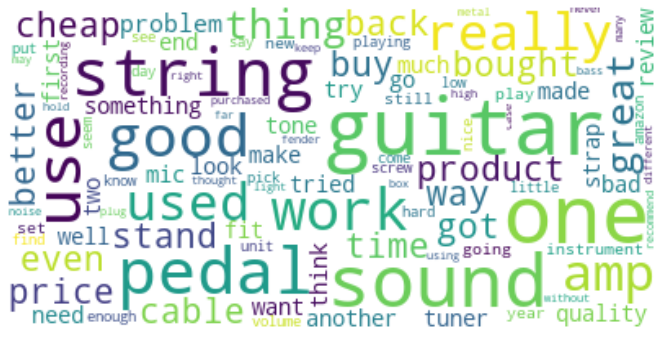

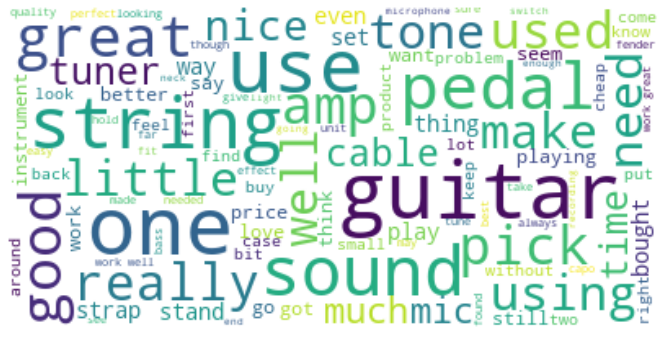

In [368]:
# reseñas nedativas
plot_word_cloud(neg_reviews)

# reseñas postivias
plot_word_cloud(pos_reviews)

## Palabras más frecuentes en todo el dataset

In [369]:
# preparamos los datos
words_data = data_tokenizer(data[['reviewText']].values)
words_data = data_lower(words_data)
words_data = stop_words(words_data)
words_data = data_lemmatizer(words_data)

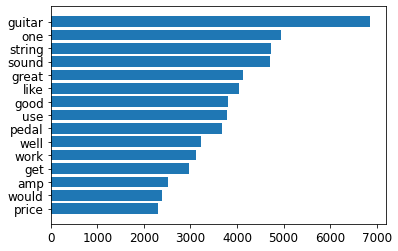

In [370]:
wf = Counter(words_data)

wf_most_common = wf.most_common(15)
words = [w[0] for w in wf_most_common]
freqs = [w[1] for w in wf_most_common]
freqs, words = zip(*sorted(zip(freqs, words)))

plt.barh(words, freqs)
plt.show()

## N-grams

Por las carcaterísticas y tamaño de las reviews consideramos hacer une stiudio con de bi tri-gramas. 

In [371]:
from nltk import ngrams
from nltk.probability import FreqDist

In [372]:
# preparación de los datos

def n_grams_freq(data, num):
  ngrams_words = list(ngrams(data, num))
  ngrams_freq = FreqDist(ngrams_words)
  return ngrams_freq

In [373]:
# visulización 

def plot_n_grams_freq(data, num):

  ngrams_freq = n_grams_freq(data, num)

  ng_freq_most_common = ngrams_freq.most_common(15)
  ngs_ = [str(ng[0]) for ng in ng_freq_most_common]
  ngs_f_ = [ng[1] for ng in ng_freq_most_common]
  ngs_f_, ngs_ = zip(*sorted(zip(ngs_f_, ngs_)))

  plt.barh(ngs_, ngs_f_)
  plt.title('Bigram frequencies')
  plt.show()

### **tri-grams**

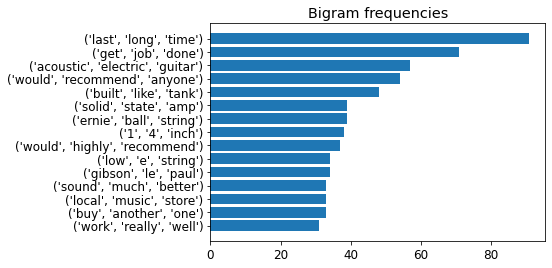

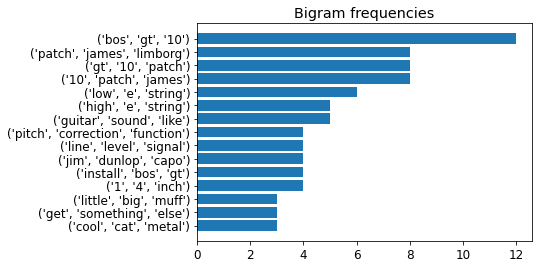

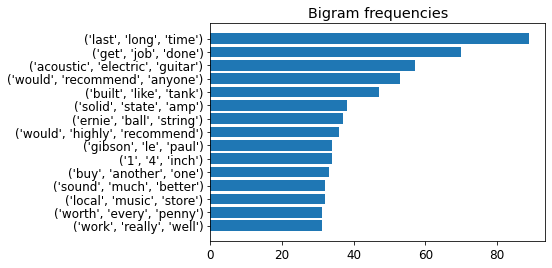

In [374]:
# todo el dataset
plot_n_grams_freq(words_data, 3)

# reseñas negativas
plot_n_grams_freq(neg_reviews, 3)

# reseñas postivias
plot_n_grams_freq(pos_reviews, 3)